In [1]:

import numpy as np
import scipy.fftpack
from scipy import ndimage
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import math
import sys
import os


data=pd.read_table('datosNGC604r.txt')

In [2]:
data.describe()

,RA,DE,Halpha,RVHalpha,SigmHalpha,[NII]6548,RV[NII]6548,Sigm[NII]6548,[NII]6584,RV[NII]6584,Sigm[NII]6584,[SII]6717,RV[SII]6717,Sigm[SII]6717,[SII]6731,RV[SII]6731,Sigm[SII]6731
count,1500.000000,1500.000000,1497.000000,1500.000000,1500.000000,1.497000e+03,1500.000000,1500.000000,1.497000e+03,1500.000000,1500.000000,1475.000000,1500.000000,1500.000000,1.475000e+03,1500.000000,1500.000000
mean,99.904500,9.390000,920.352503,-806.416087,83.475644,2.674423e+03,-834.243945,74.894615,8.020595e+03,-810.271697,74.452375,105.036422,-5215.925607,47.840685,1.958644e+12,-5241.719214,47.702254
std,58.085078,6.252917,2624.750671,13389.980282,348.636537,9.772014e+04,13388.255744,252.553948,2.930571e+05,13389.322780,251.221405,218.638500,38363.413828,281.044179,7.522315e+13,38360.054292,280.421940
min,0.000000,0.000000,-5108.000000,-299792.000000,0.000000,-6.668000e+01,-299792.000000,0.000000,-2.000000e+02,-299792.000000,0.000000,-695.300000,-299792.000000,0.000000,-6.323000e+05,-299792.000000,0.000000
25%,49.617000,4.000000,-14.620000,-277.337749,8.578435,3.071000e+00,-287.407495,10.154780,9.214000e+00,-263.109263,10.021200,2.705500,-244.585366,0.000000,1.754000e+00,-270.763708,0.000000
50%,99.904500,9.000000,47.630000,-267.002536,16.510678,6.889000e+00,-276.282044,17.402472,2.067000e+01,-252.042963,17.263627,16.630000,-232.611095,12.111469,1.180000e+01,-258.816121,12.042395
75%,150.192000,15.000000,615.400000,-152.241694,50.274305,4.467000e+01,-219.693328,74.357319,1.340000e+02,-195.755113,73.951154,119.450000,-215.057014,29.091392,8.495000e+01,-241.301160,29.009066
max,199.809000,19.600000,30960.000000,2589.901754,5770.228814,3.778000e+06,874.378072,6480.291011,1.133000e+07,892.499410,6445.836962,2329.000000,533.786887,5542.682685,2.889000e+15,505.873947,5530.330752


Halpha Line

/home/zalenovo/my_project_dir/my_project_env/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


(-9.99564490057674, 209.80464490057673, -0.987998770755577, 20.58799877075558)

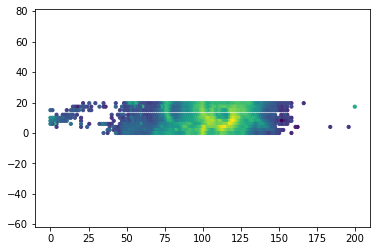

In [3]:
plt.scatter(data.RA,data.DE,c=np.log10(data.Halpha), s=10)
plt.axis('equal')

(0.0, 150.0, 0.0, 10.0)

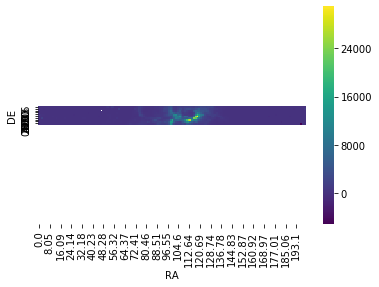

In [4]:
data_2=(data.round(2)).pivot(index='DE', columns='RA', values='Halpha')
sns.heatmap(data_2, cmap="viridis")
plt.gca().invert_yaxis()
plt.axis('equal')

Filter on Coordinates

In [5]:
m=(data.RA<145)&(data.RA>60)
data=data[m]
data.describe()

,RA,DE,Halpha,RVHalpha,SigmHalpha,[NII]6548,RV[NII]6548,Sigm[NII]6548,[NII]6584,RV[NII]6584,Sigm[NII]6584,[SII]6717,RV[SII]6717,Sigm[SII]6717,[SII]6731,RV[SII]6731,Sigm[SII]6731
count,640.000000,640.000000,640.000000,640.000000,640.000000,640.000000,640.000000,640.000000,640.000000,640.000000,640.000000,640.000000,640.000000,640.000000,640.000000,640.000000,640.000000
mean,102.586500,9.390000,2140.992531,-274.989700,13.433349,104.543542,-269.954372,25.445700,313.625038,-245.748933,25.248202,223.014633,-228.854209,28.877310,158.977348,-255.071992,28.762246
std,24.791606,6.255721,3669.615144,10.636030,7.886727,144.497189,44.714496,43.084068,433.470252,44.476761,42.873224,254.340701,29.586134,245.164716,198.794770,29.520313,244.622565
min,60.345000,0.000000,24.400000,-303.272854,0.000000,1.752000,-321.722417,0.000000,5.255000,-297.241741,0.000000,-25.030000,-337.288319,0.000000,-1343.000000,-363.260073,0.000000
25%,81.465750,4.000000,167.025000,-282.865090,8.934141,14.157500,-286.480374,10.479894,42.470000,-262.187072,10.347073,38.932500,-240.065720,5.118591,25.697500,-266.298673,5.006794
50%,102.586500,9.000000,880.800000,-275.042304,12.289029,57.050000,-279.257988,13.898669,171.150000,-255.003084,13.766730,146.700000,-233.057479,10.413592,100.860000,-259.261511,10.341411
75%,123.707250,15.000000,2260.250000,-268.784075,16.370471,132.075000,-270.673535,20.186435,396.275000,-246.464272,20.039190,313.350000,-225.234587,17.074847,225.575000,-251.467187,17.006972
max,144.828000,19.600000,30960.000000,-231.143341,60.414211,1298.000000,43.265644,256.286125,3893.000000,65.805779,254.920381,2137.000000,91.196405,5029.368305,1568.000000,64.269775,5018.160282


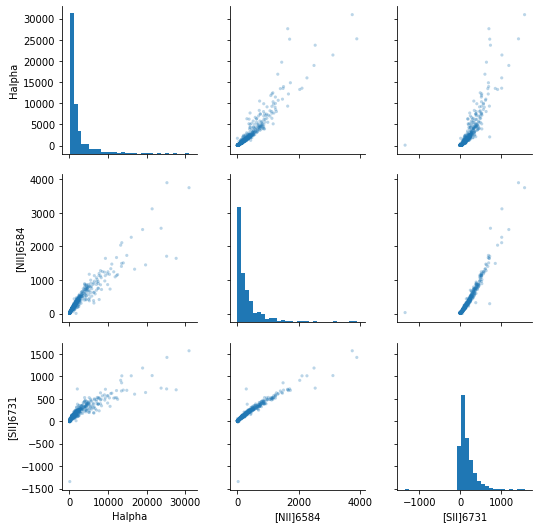

In [6]:
sns.pairplot(data,
             vars=["Halpha", "[NII]6584", "[SII]6731"],
             diag_kind='hist',
             plot_kws=dict(alpha=0.3, s=10, edgecolor='none'),
             diag_kws=dict(bins=30),
            )

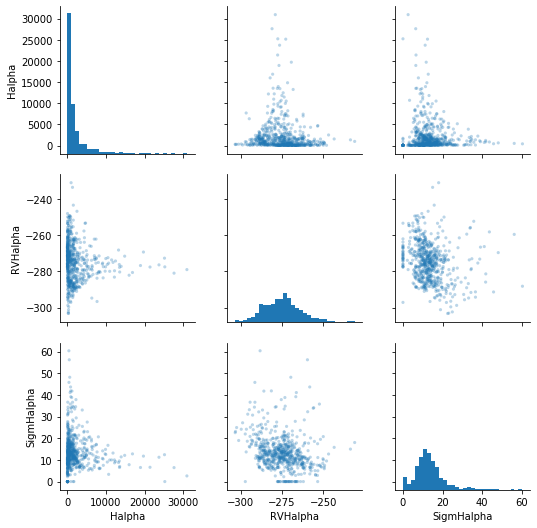

In [7]:
sns.pairplot(data,
             vars=["Halpha", "RVHalpha", "SigmHalpha"],
             diag_kind='hist',
             plot_kws=dict(alpha=0.3, s=10, edgecolor='none'),
             diag_kws=dict(bins=30),
            )

(56.10982995172379, 149.0631700482762, -0.9969679551272751, 20.596967955127276)

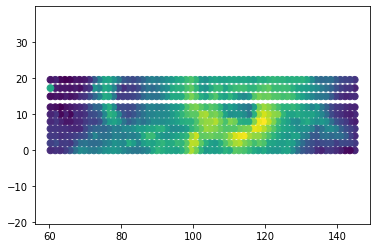

In [8]:
plt.scatter(data.RA,data.DE,c=np.log10(data.Halpha), s=45)
plt.axis('equal')

In [9]:
datal=data.copy()
datal.Halpha=np.log10(datal.Halpha)
dataH_f=(datal.round(2)).pivot(index='DE', columns='RA', values='Halpha')
dataH_rv=(datal.round(2)).pivot(index='DE', columns='RA', values='RVHalpha')
dataH_s=(datal.round(2)).pivot(index='DE', columns='RA', values='SigmHalpha')

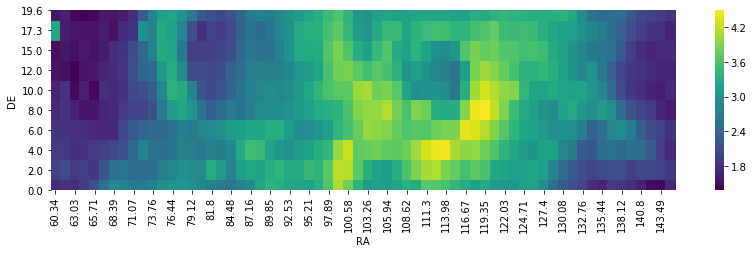

In [10]:
fig, ax = plt.subplots(figsize=(14, 3.3))
sns.heatmap(dataH_f, cmap="viridis")
plt.gca().invert_yaxis()

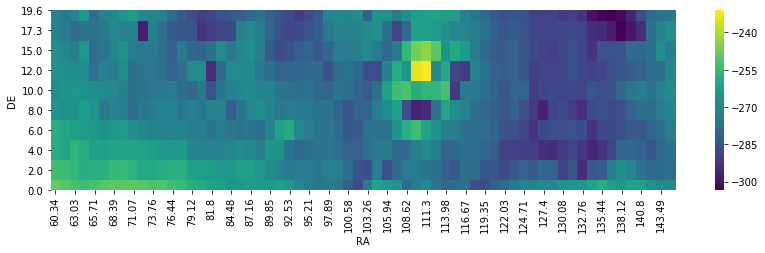

In [11]:
fig, ax = plt.subplots(figsize=(14, 3.3))
sns.heatmap(dataH_rv, cmap="viridis")
plt.gca().invert_yaxis()

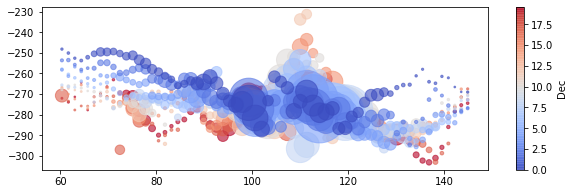

In [12]:
fig, ax = plt.subplots(figsize=(10, 3))
scat = plt.scatter(data.RA, data.RVHalpha, c=data.DE, s=data.Halpha*0.1, alpha=0.6, cmap="coolwarm")
fig.colorbar(scat, ax=ax).set_label("Dec")
#ax.set(xlim=[65.0, 145.0])

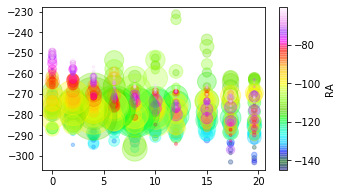

In [13]:
fig, ax = plt.subplots(figsize=(5, 3))
scat = plt.scatter(data.DE, data.RVHalpha, c=-data.RA, s=data.Halpha*0.08, alpha=0.3, cmap="gist_ncar")
fig.colorbar(scat, ax=ax).set_label("RA")

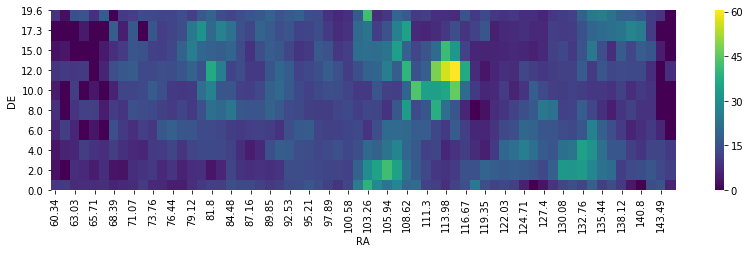

In [14]:
fig, ax = plt.subplots(figsize=(14, 3.3))
sns.heatmap(dataH_s, cmap="viridis")
plt.gca().invert_yaxis()

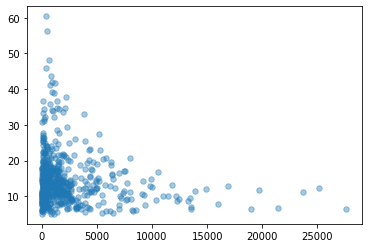

In [15]:
m1=(data.SigmHalpha>5)
plt.scatter(data[m1].Halpha,data[m1].SigmHalpha, alpha=0.4, s=30)

[NII]

In [16]:
dataN=data.copy()

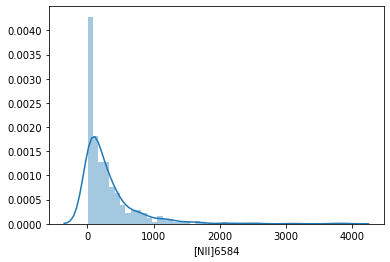

In [17]:
sns.distplot(dataN['[NII]6584'])

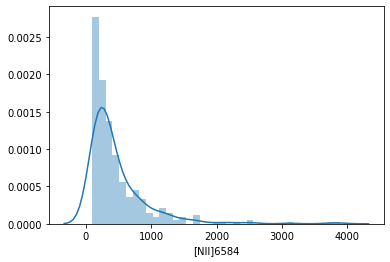

In [18]:
mnf=(dataN['[NII]6584']<4000)&(dataN['[NII]6584']>100)
sns.distplot(dataN[mnf]['[NII]6584'])

In [19]:
dataN=dataN[mnf]

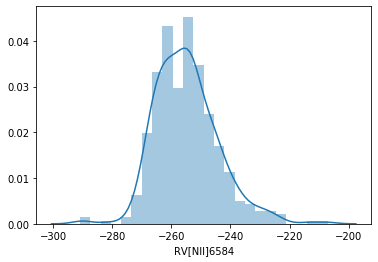

In [20]:
sns.distplot(dataN['RV[NII]6584'])

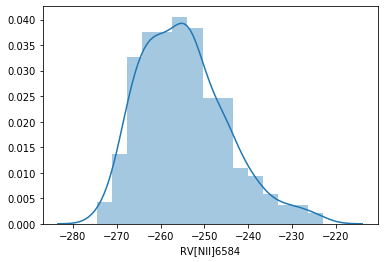

In [21]:
mnrv=(dataN['RV[NII]6584']>-280)&(dataN['RV[NII]6584']<-220)
sns.distplot(dataN[mnrv]['RV[NII]6584'])

In [22]:
dataN=dataN[mnrv]

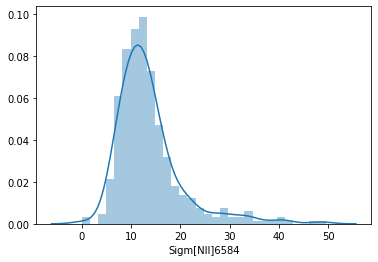

In [23]:
sns.distplot(dataN['Sigm[NII]6584'])

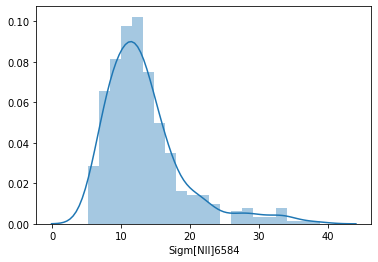

In [24]:
mns=(dataN['Sigm[NII]6584']>5)&(dataN['Sigm[NII]6584']<40)
sns.distplot(dataN[mns]['Sigm[NII]6584'])

In [25]:
dataN=dataN[mns]

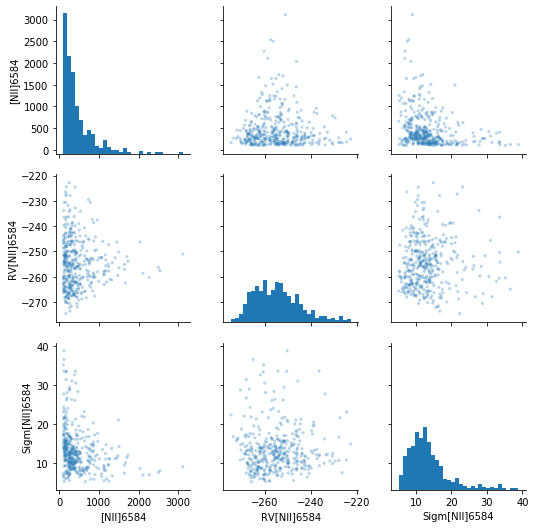

In [26]:
sns.pairplot(dataN,
             vars=["[NII]6584", "RV[NII]6584", "Sigm[NII]6584"],
             diag_kind='hist',
             plot_kws=dict(alpha=0.3, s=10, edgecolor='none'),
             diag_kws=dict(bins=30),
            )

In [27]:
dataNl=dataN.copy()
dataNl.Halpha=np.log10(data['[NII]6584'])
dataN_f=(dataN.round(2)).pivot(index='DE', columns='RA', values='[NII]6584')
dataN_rv=(dataN.round(2)).pivot(index='DE', columns='RA', values='RV[NII]6584')
dataN_s=(dataN.round(2)).pivot(index='DE', columns='RA', values='Sigm[NII]6584')

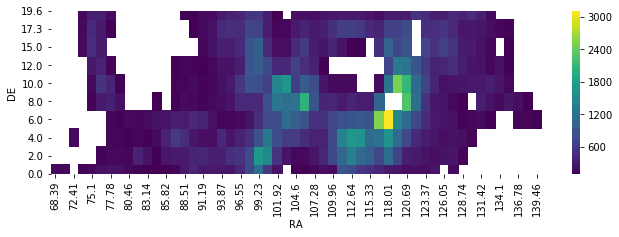

In [28]:
fig, ax = plt.subplots(figsize=(11, 3))
sns.heatmap(dataN_f, cmap="viridis")
plt.gca().invert_yaxis()

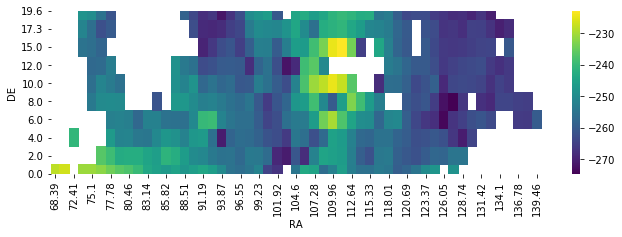

In [29]:
fig, ax = plt.subplots(figsize=(11, 3))
sns.heatmap(dataN_rv, cmap="viridis")
plt.gca().invert_yaxis()


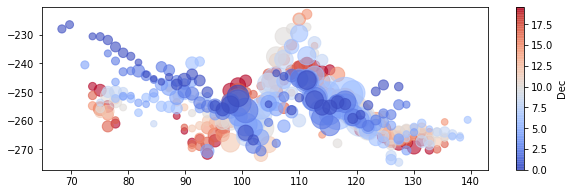

In [30]:
fig, ax = plt.subplots(figsize=(10, 3))
scat = plt.scatter(dataN.RA, dataN['RV[NII]6584'], c=dataN.DE, s=dataN['[NII]6584']*0.4, alpha=0.6, cmap="coolwarm")
fig.colorbar(scat, ax=ax).set_label("Dec")

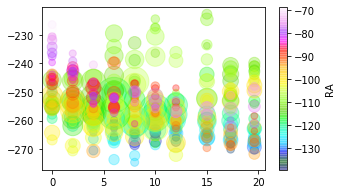

In [31]:
fig, ax = plt.subplots(figsize=(5, 3))
scat = plt.scatter(dataN.DE, dataN['RV[NII]6584'], c=-dataN.RA, s=dataN['[NII]6584']*0.4, alpha=0.3, cmap="gist_ncar")
fig.colorbar(scat, ax=ax).set_label("RA")

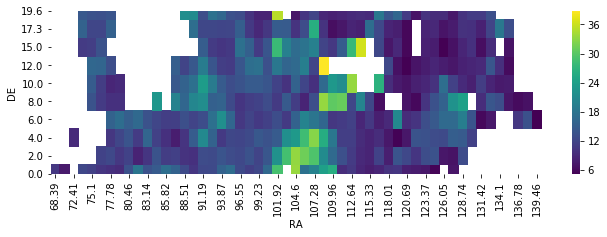

In [32]:
fig, ax = plt.subplots(figsize=(11, 3))
sns.heatmap(dataN_s, cmap="viridis")
plt.gca().invert_yaxis()

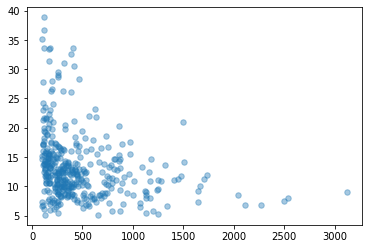

In [33]:
plt.scatter(dataN['[NII]6584'],dataN['Sigm[NII]6584'], alpha=0.4, s=30)

[SII]

In [34]:
dataS=data.copy()

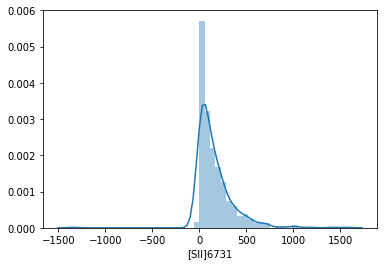

In [35]:
sns.distplot(dataS['[SII]6731'])

In [36]:
dataSl=data.copy()
dataSl.Halpha=np.log10(data['[SII]6731'])
dataS_f=(datal.round(2)).pivot(index='DE', columns='RA', values='[SII]6731')
dataS_rv=(datal.round(2)).pivot(index='DE', columns='RA', values='RV[SII]6731')
dataS_s=(datal.round(2)).pivot(index='DE', columns='RA', values='Sigm[SII]6731')